## Análisis de Datos: Medidas de posición y rangos

Igual que vimos las frecuencias para poder analizar la distribución de datos categóricos nominales y binarios, empezamos con esta sesión las dedicadas a analizar hasta cierto punto la distribución y dispersión de los datos numéricos y ordinales. Empecemos con el concepto de percentil, después de cargar nuestros datos y librerías:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_seguros = pd.read_csv("C:/Users/david/Downloads/Marketing-Customer-Analysis.csv")
df_air_jun = pd.read_csv("C:/Users/david/Downloads/dataset_viajes_jun23.csv")
df_air_jul = pd.read_csv("C:/Users/david/Downloads/dataset_viajes_jul23.csv")

In [2]:

def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()




In [11]:
def plot_boxplot_grouped(df, column_to_plot, group_column):
    if df[column_to_plot].dtype in ['int64', 'float64'] and df[group_column].dtype in ['object', 'category']:
        sns.boxplot(data=df, x=group_column, y=column_to_plot)
        plt.show()



### Percentil
El percentil es el valor que divide un conjunto ordenado de datos estadísticos de forma que un porcentaje de tales datos sea inferior a dicho valor.

**Teniendo la variable ordenada en sentido ascendente, el percentil representa el orden relativo de cada valor respecto al resto de variables.**

Por ejemplo, si en una clase hay 100 alumnos, y en un examen solo tenemos 4 personas que hayan sacado mejor nota que nosotros, estaremos en el percentil 95%. De la misma manera el percentil 20% lo marcaría la nota por debajo de la cual se encuentra el 20% de la case.

Considerando nuestros ejemplos, el percentil 45%, por ejemplo de los ingresos de los viajes sería el valor de ingresos por debajo del cual estarían el 45% de los viajes. Y el percentil 73, o 73%, del CLV de los seguros sería ese valor que no superará el CLV del 73% de los clientes. 

Para calcular el percentil 20% en el ejemplo de las notas hay que ordenar la variable de forma ascendente y buscar al alumno 20 ordenado de esa forma, su nota será la que marque ese percentil. Y esto es así porque son 100 claro, si fueran 200, el percentil veinte lo marcaría la nota del alumno en la posición 40, ordenados por notas de menor a mayor, etc, etc.

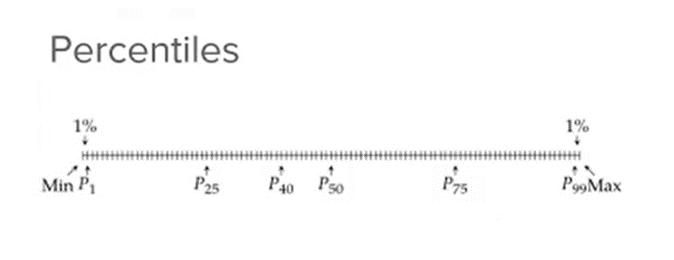

Por cierto, si recuerdas, la mediana es equivalente al percentil 50.

En pandas tenemos el método `quantile` para calcular los percentiles y en numpy la función `percentile`.

Por ejemplo si quiero el grado de dispersión en el CLV de los seguros, donde sé que la media y la mediana se separan entre otras cosas por que el valor máximo es muy alto, puedo acudir a ver los percentiles siguientes:

In [3]:
print(df_seguros["customer_lifetime_value"].quantile(0.5),
    df_seguros["customer_lifetime_value"].quantile(0.9), 
      df_seguros["customer_lifetime_value"].quantile(0.95),
     df_seguros["customer_lifetime_value"].max())


5780.182197 15433.385306000006 22064.3612665 83325.38119


Fijate que el 50% de los CLVs son menores de 5780, pero luego el siguiente 40%, está entre 5780 y 15400 (un rango de 10K casi el doble que los otros 50%) y que un 5% está entre 15K y 22K pero luego otro 5% está en un márge de casi 60K$. Es decir se presiente esa dispersión. Pero es difícil todavía de "verla", para ello antes veamos unos percentiles particulares muy empleados, los quartiles.

### Quartiles
Los **[cuartiles](https://es.wikipedia.org/wiki/Cuartil)** son los tres valores de la variable estadística que dividen a un [conjunto de datos](https://es.wikipedia.org/wiki/Conjunto_de_datos) ordenados en cuatro partes iguales. Q1, Q2 y Q3 determinan los valores correspondientes a **los percentiles 25%, al 50% y al 75% de los datos**. Q2 coincide con la <a href="https://es.wikipedia.org/wiki/Mediana_(estad%C3%ADstica)">mediana</a>.

Podemos obtener los valores de los cuartiles utilizando los métodos y funciones comentados de pandas y numpy, pero también directamente del método `describe`.

In [4]:
df_air_jun.describe()

,distancia,consumo_kg,duracion,ingresos
count,600.000000,600.000000,600.000000,6.000000e+02
mean,8071.003333,68240.520508,635.873333,4.187689e+05
std,5550.244086,67441.849592,450.474786,3.182858e+05
min,344.000000,835.920000,42.000000,1.179785e+04
25%,3073.000000,15733.520400,224.000000,1.627668e+05
50%,6877.000000,36033.998000,542.000000,3.754817e+05
75%,12553.000000,111717.652800,876.000000,6.188420e+05
max,20029.000000,264876.314560,1721.000000,1.295516e+06


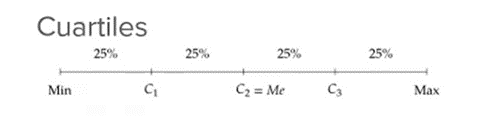

Los cuartiles son los que normalmente se usan para ver a través de números un cierto grado de dispersión en concreto se usa un concepto denominado "rango intercuartílico" o `IQR` que es la diferencia entre el percentil 75% y el percentil 25% y,por tanto es un rango de valores entre los que se encuentra el 50% de los valores que no están en un extremo ni en el otro.

Creemos una sencilla función que dado un dataframe y una columna nos diga su indice intercuantílico:

In [5]:
def get_IQR(df, col):
    return df[col].quantile(0.75) - df[col].quantile(0.25)

In [6]:
get_IQR(df_seguros,"customer_lifetime_value")

np.float64(4967.915247000001)

Y eso ¿es mucho o poco? Pues... depende... varias formas de aplicarlo:
* Si el IQR es mucho mayor que la mediana (por ejemplo más de un 50%) podríamos pensar en una variable con valores bastante dispersos (y por tanto las medidas de tendencia central hay que considerarlas con más cuidado)
* Podemos comparar el IQR con la diferencia entre valor máximo y mínimo (lo que veremos en un momento que es el rango) y si el IQR es comparable entonces de nuevo podremos hablar de una variable dispersa.

En el caso del CLV:


In [7]:
df_seguros["customer_lifetime_value"].describe()

count     9134.000000
mean      8004.940475
std       6870.967608
min       1898.007675
25%       3994.251794
50%       5780.182197
75%       8962.167041
max      83325.381190
Name: customer_lifetime_value, dtype: float64

Si comparamos ni el IQR es mayor que la mediana, ni es una proporción importante del rango (más de 82K$), no es el CLV una variable dispersa, pero sí que tiene valores potencialmente anómalos pero eso lo veremos en otras sesiones. Ahora para casi terminar veamos la forma visual de analizar los cuartiles, la dispersión y en el futuro las anomalías de valores numéricos.

###  Diagramas de caja
Los [diagramas de cajas](https://es.wikipedia.org/wiki/Diagrama_de_caja) son una presentación visual que describe varias características importantes al mismo tiempo, tales como la dispersión y simetría. Para su realización se representan los tres cuartiles y los valores mínimo y máximo de los datos, sobre un rectángulo, alineado horizontal o verticalmente. Estos gráficos nos proporcionan abundante información y son sumamente útiles para encontrar [valores atípicos](https://es.wikipedia.org/wiki/Valor_at%C3%ADpico) y comparar dos [conjunto de datos](https://es.wikipedia.org/wiki/Conjunto_de_datos). 


<img src="https://miro.medium.com/max/18000/1*2c21SkzJMf3frPXPAR_gZA.png" width="500" height="550">


Por cierto a las líneas entre la caja y los valores "Minimum" y "Maximum" (ojo que no son el min y el max) se le denomina también "bigotes". Cuanto más alargada la caja o más largos los bigotes más dispersos son los valores de la variable pintada. Los valores que quedan por debajo del minimum y del maximum son considerados outliers o anomalías. [Como hemos comentado antes lo veremos en las sesiones finales de la unidad]. 

Antes de aplicarlo a los dos casos (esta vez he preferido no hacerte pasar por la versión numérica de los valores de posición), simplemente comentar que usaremos los boxplot:
1. Para **comparar series de valores entre sí** por ejemplo como son las distribuciones de CLV para cada tipo cliente según su estado.
2. Para **detectar valores anómalos** o outliers.

Cada uno de estos puntos los veremos en su correspondiente sesión. Ahora pintemos diagramas de cajas.

#### Caso 1. Seguros: Percentiles y BoxPlots

In [8]:
# Primero necesitamos las columnas numéricas:
columnas_numericas_customers = [
    "customer_lifetime_value",
    "income",
    "monthly_premium_auto",
    "months_since_last_claim",
    "months_since_policy_inception",
    "number_of_open_complaints",
    "number_of_policies",
    "total_claim_amount"
]
columnas_numericas_customers = df_seguros.describe().T.index.to_list()
print(columnas_numericas_customers)


['customer_lifetime_value', 'income', 'monthly_premium_auto', 'months_since_last_claim', 'months_since_policy_inception', 'number_of_open_complaints', 'number_of_policies', 'total_claim_amount']


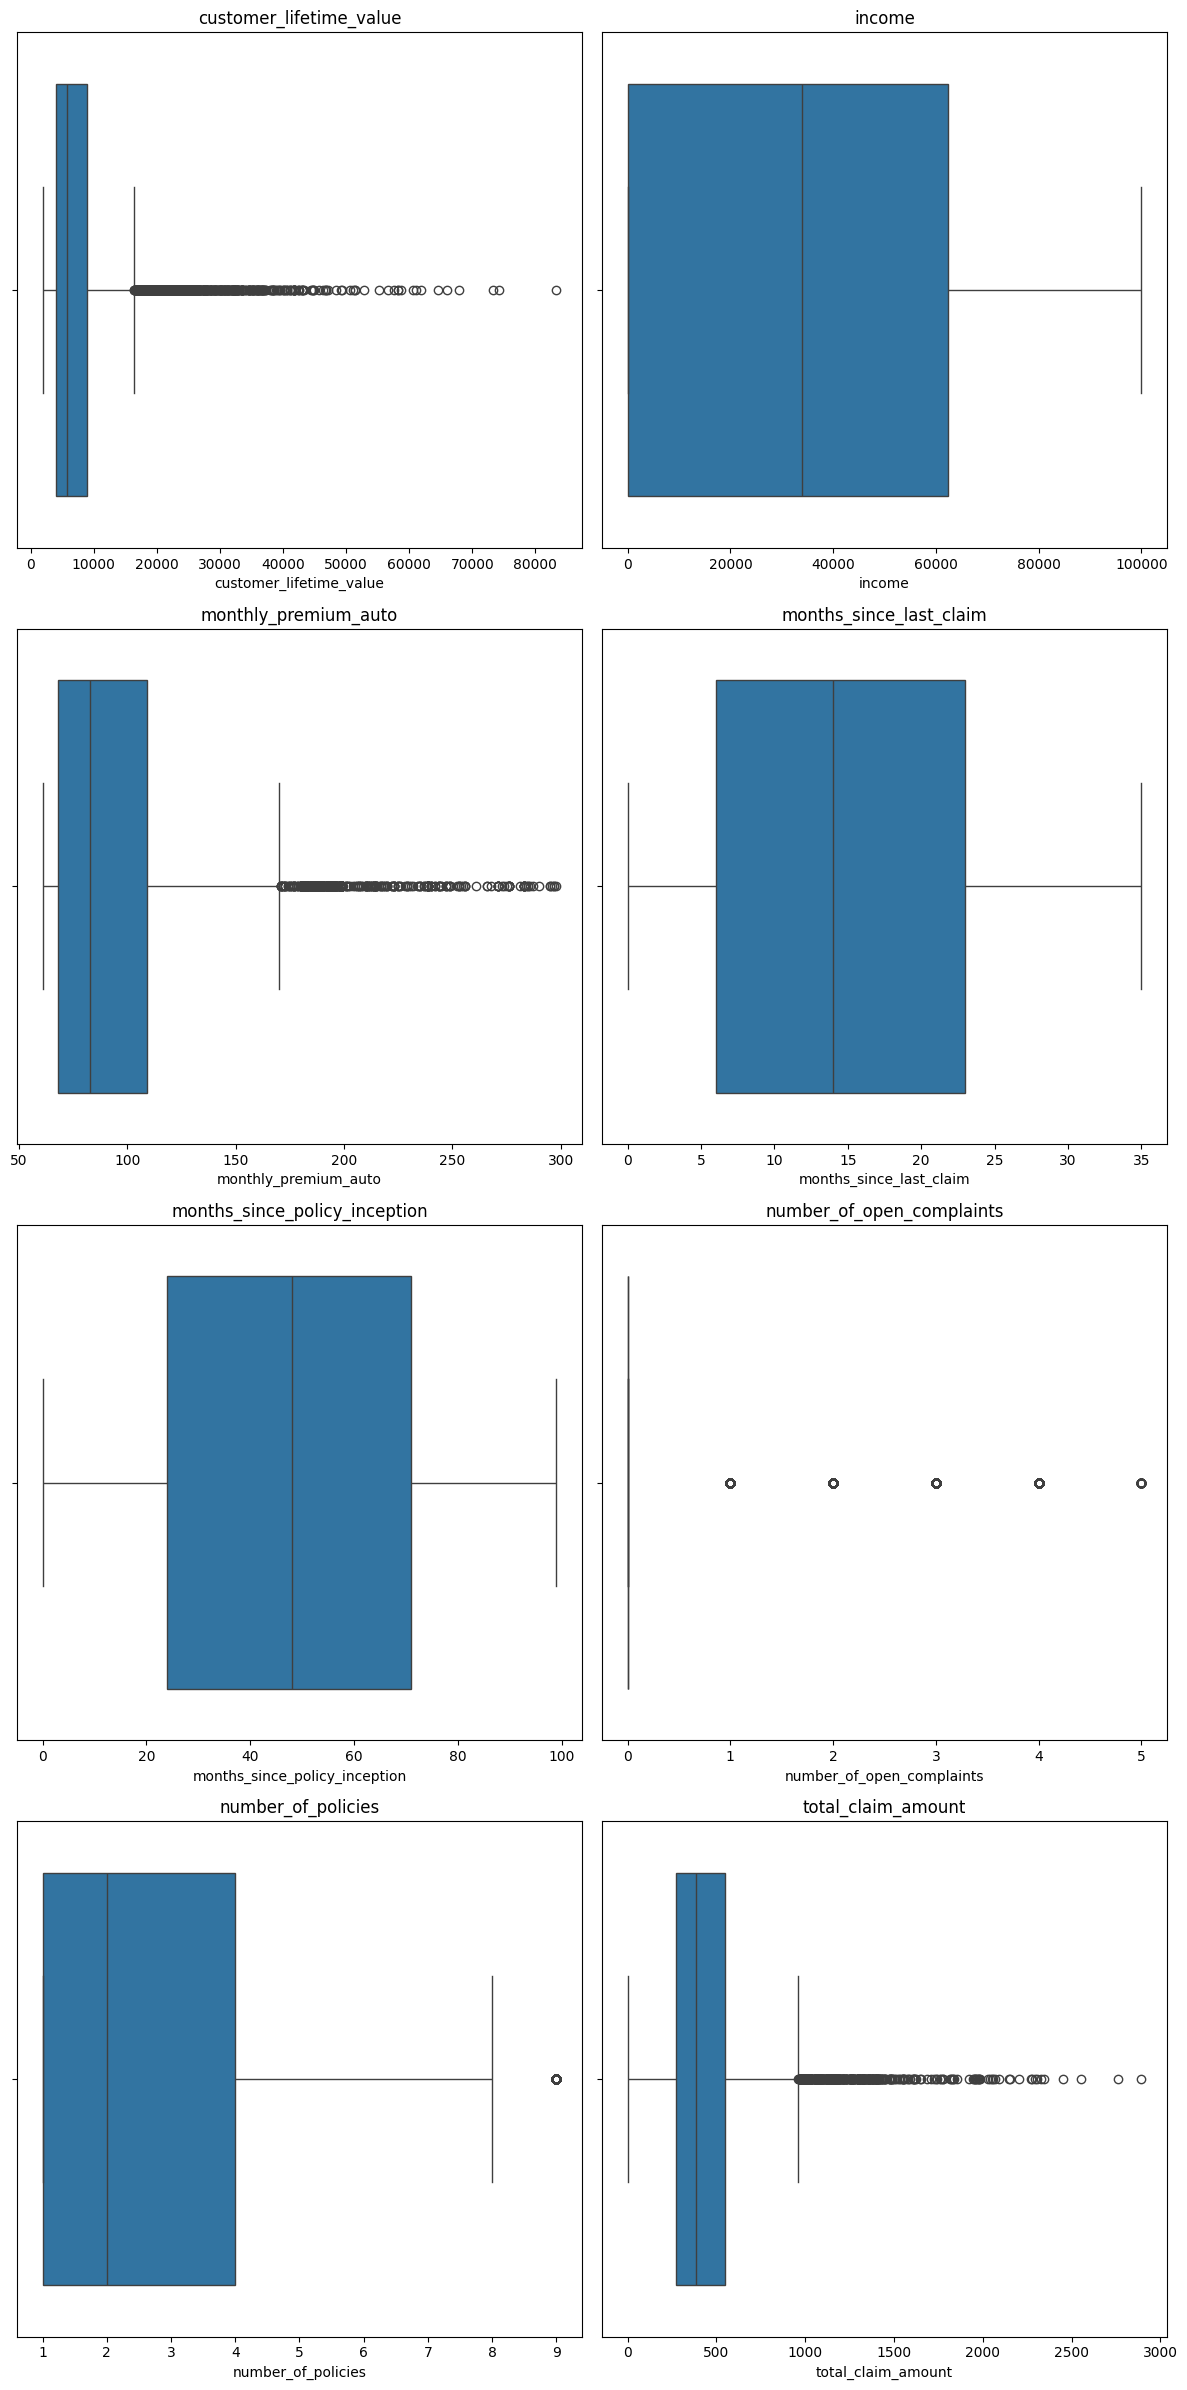

In [9]:
plot_multiple_boxplots(df_seguros, columnas_numericas_customers)

¿Qué observas?
- En general no parecen variables muy dispersas, pero más sobre eso en la siguiente píldora, pero sí que hay al menos un par de ellas con bastantes valores anómalos CLV, total_claim_amount y monthly_premium_alto.
- Dado que una de ellas es una de las variables directoras, tendremos que tenerlo en cuenta para analizar mejor esa distribución y esos valores anómalos antes de comparar CLV con el resto de variables demográficas y categóricas.

Por cierto, te dejo (a modo de Teaser/anticipo para la siguiente unidad) un ejemplo de como se distribuye CLV, sin tocar, entre clientes que responden que sí y no a las ofertas de marketing:

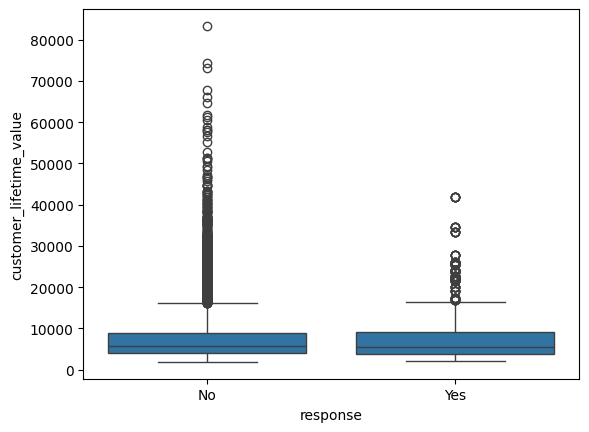

In [12]:
plot_boxplot_grouped(df_seguros, "customer_lifetime_value", "response")

¿Qué ves?

#### Caso 2. Viajes: Boxplots

Esta aplicación y su análisis la tendrás como ejercicio de esta unidad.

### Rangos

Para terminar, un tema sencillo, obtener los rangos de cada varible numérica, es decir hacer la diferencia entre su valor máximo y su valor mínimo:

In [13]:
df_seguros.describe().loc["max"] - df_seguros.describe().loc["min"]

customer_lifetime_value          81427.373515
income                           99981.000000
monthly_premium_auto               237.000000
months_since_last_claim             35.000000
months_since_policy_inception       99.000000
number_of_open_complaints            5.000000
number_of_policies                   8.000000
total_claim_amount                2893.140671
dtype: float64

In [14]:
df_air_jun.describe().loc["max"] - df_air_jun.describe().loc["min"]

distancia     1.968500e+04
consumo_kg    2.640404e+05
duracion      1.679000e+03
ingresos      1.283718e+06
dtype: float64

En ambos casos los rangos nos sirven más para comparar y como referencia que como un dato a analizar de primeras. 


In [15]:
df_seguros.describe().loc["max"] - df_seguros.describe().loc["min"]

customer_lifetime_value          81427.373515
income                           99981.000000
monthly_premium_auto               237.000000
months_since_last_claim             35.000000
months_since_policy_inception       99.000000
number_of_open_complaints            5.000000
number_of_policies                   8.000000
total_claim_amount                2893.140671
dtype: float64

In [17]:
df_air_jun.describe().loc["max"] - df_air_jun.describe().loc["min"]

distancia     1.968500e+04
consumo_kg    2.640404e+05
duracion      1.679000e+03
ingresos      1.283718e+06
dtype: float64